### First Load the data and prepare training and testing images

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import os


# a function which reads images from a directory
def read_images(dirpath = '../data' ):
    X, y = [], []
    
    image_size = None
    for filename in os.listdir(dirpath):
        image_path = os.path.join(dirpath, filename)
        im = Image.open(image_path)
        im = im.convert('L')
        subject = filename.split('_')[0]
        image_size = np.asarray(im).shape
        X.append(np.asarray(im, dtype=np.uint8).reshape(1, -1))
        person,_ = subject.split(".")
        y.append(person)

    X = np.vstack(X)
    return  X, np.asarray(y), image_size


# Load the data
all_images, all_classes, (height, width) = read_images()

all_images = np.array(all_images)
all_classes = np.array(all_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_classes, test_size=0.1, random_state=40)
print(X_train.shape)
print(X_test.shape)
        
print(y_train.shape) 
print(y_test.shape)



(148, 77760)
(17, 77760)
(148,)
(17,)


### Reduce the dimensions using principal component analysis

In [8]:
# now reduce the dimension of the data using PCA
def pca(X, num_components):

    mu = X.mean(axis=0)
    X = X - mu
    C = np.dot(X, X.T)
    eigen_values, eigen_vectors = np.linalg.eigh(C)        

    eigen_vectors  = np.dot(X.T , eigen_vectors)

    # normalize the eigen vectors
    n = eigen_vectors.shape[1]
    for i in range(n):
        eigen_vectors[:, i] = eigen_vectors[:, i] / np.linalg.norm(eigen_vectors[:, i])
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    eigen_values, eigen_vectors = eigen_values[:num_components].copy() , eigen_vectors[:, :num_components].copy()

    return [eigen_values, eigen_vectors, mu]
classes = np.unique(y_train)


_, w, training_mean = pca(X_train,X_train.shape[0] - classes.shape[0])

# project x_train into the reduced dimension
x_train_projected = np.dot(X_train - training_mean, w)


In [27]:
def lda(X , y , num_components):
    total_mean = X.mean(axis = 0)
    d = X.shape[1]
    subjects = np.unique(y)

    Sw = np.zeros((d, d) , dtype = np.float32 )
    Sb = np.zeros((d, d), dtype = np.float32 )
    n = subjects.shape[0]

    for subject in subjects:
        Xi = X[np.where(y == subject)[0], :]
        class_mean = Xi.mean(axis = 0)
        Sw = Sw + np.dot (( Xi - class_mean ).T, ( Xi - class_mean ))
        Sb = Sb +  n * np.dot((total_mean - class_mean).T, total_mean - class_mean) 

    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv( Sw ) * Sb )

    idx = np.argsort(-eigenvalues.real)
    eigenvalues , eigenvectors = eigenvalues [ idx ], eigenvectors [: , idx ]
    eigenvalues = np.array ( eigenvalues [0: num_components ].real , dtype = np.float32 , copy = True )
    eigenvectors = np.array ( eigenvectors [0: ,0: num_components ].real , dtype = np.float32 ,copy = True )
    
    return eigenvalues , eigenvectors

def predict(X_proj, query_projection, y_train):
    N = y_train.shape[0]

    diff = float('inf')
    predict_label = None
    closest_proj = None
    for i in range(N):

        dist = np.linalg.norm(query_projection - X_proj[i, :])

        if dist < diff:
            diff = dist
            predict_label = y_train[i]
            predict_label_idx = i
            closest_proj = X_proj[i, :]
    
    return predict_label_idx,predict_label, closest_proj

### Find facespace from generalized matrix by using Linear Discriminant analysis (LDA)

In [10]:
def calculate_accuracy(train_proj, test_data, test_labels, train_labels, weight, avg_face, image_size, components):
    total_tests = test_data.shape[0]
    correct_predictions = 0
    print(f'\nComponent Count: {components}')
    
    correct_predictions = sum([process_test_image(i, train_proj, test_data, test_labels, train_labels, weight, avg_face, image_size) for i in range(total_tests)])
    
    return correct_predictions / total_tests

def process_test_image(index, train_proj, test_data, test_labels, train_labels, weight, avg_face, image_size):
    test_image = test_data[index]
    test_projection = np.dot(test_image - avg_face , weight)
    result, result_proj = predict(train_proj, test_projection, train_labels)
    # reconstruct_image(result_proj, test_image, weight, avg_face, image_size)
    print("Result: ")
    if result == test_labels[index]:
        print('Prediction is correct.')
        return 1
    else:
        print('Prediction is incorrect.')
        return 0

def reconstruct_image(result_proj, test_image, weight, avg_face, image_size):
    img_reconstruct = np.dot(result_proj, weight.T) + avg_face
    original_image = test_image.reshape(image_size)
    reconstructed_image = img_reconstruct.reshape(image_size)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image, cmap='gray')


In [30]:
def compute_accuracy(X_proj_train, X_test, y_test,y_train, W, mean_face, img_size, num_components):
    test_size = X_test.shape[0]
    correct = 0
    print(f'\nNumber of Components: {num_components}')
    
    for indx in range(test_size):

        query_image = X_test[indx]
        query_projection = np.dot(query_image - mean_face , W)
        res_idx, res, res_proj = predict(X_proj_train, query_projection, y_train)
        img_reconstruct = np.dot(res_proj, W.T) + mean_face
        correct += int(res == y_test[indx])

        
        # shows the reconstructed image for the first test image and the 13one -> for demonstration 
        original_image = query_image.reshape(img_size)
        reconstructed_image = img_reconstruct.reshape(img_size)
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title("Predicted Image")
        predicted_person_path = os.path.join("../data",y_train[res_idx] + '.normal' )
        predicted_person = Image.open(predicted_person_path)


        plt.imshow(predicted_person, cmap='gray')

        plt.show()
        
        if res == y_test[indx]:
            print("correct")
        
        else:
            print("Incorrect")

    
    return correct / test_size

# Lets finally test the model


Number of Components: 100


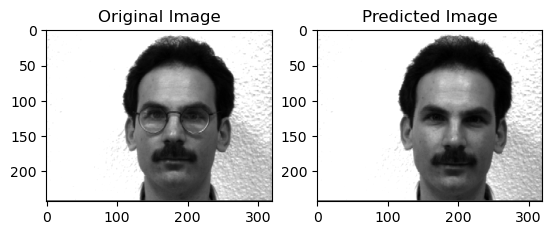

correct


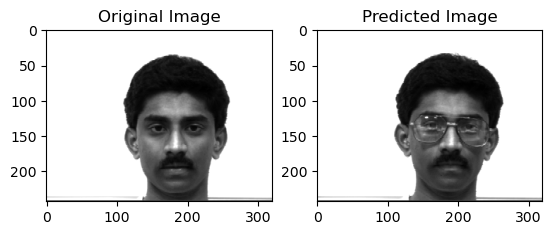

correct


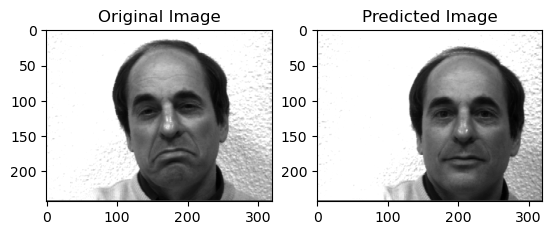

correct


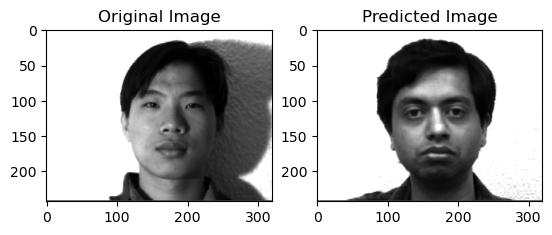

Incorrect


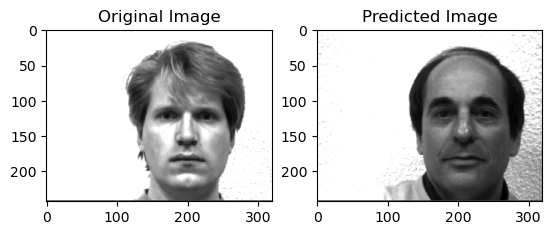

Incorrect


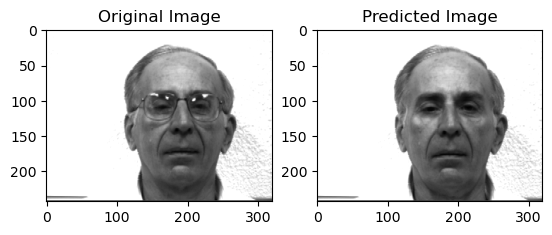

correct


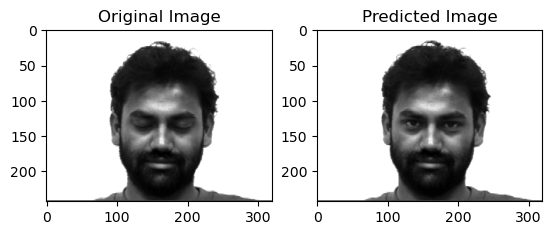

correct


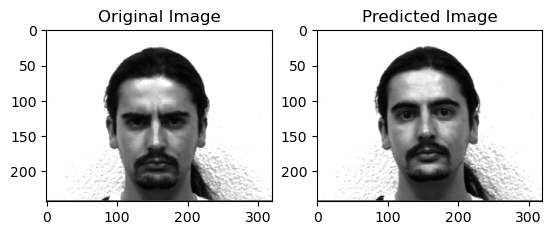

correct


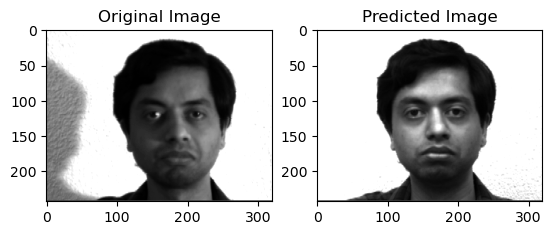

correct


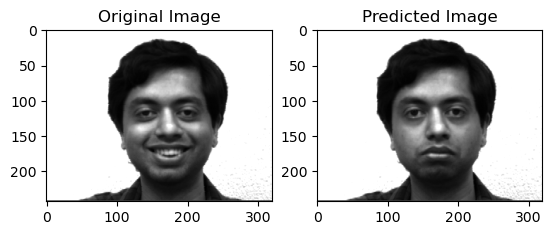

correct


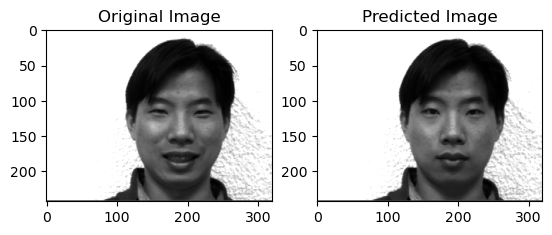

correct


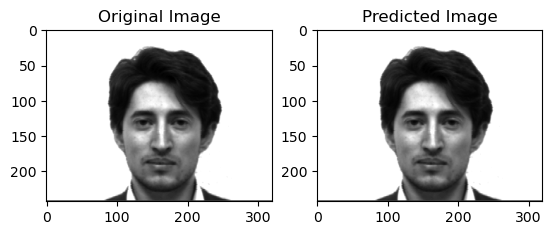

correct


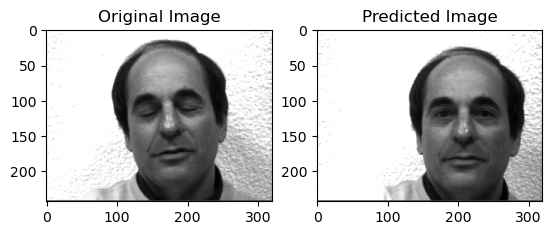

correct


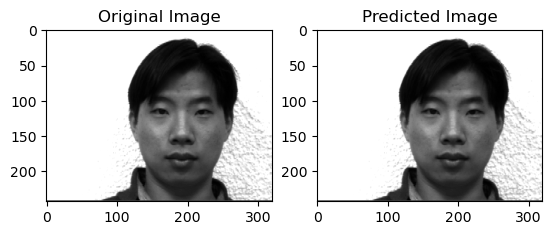

correct


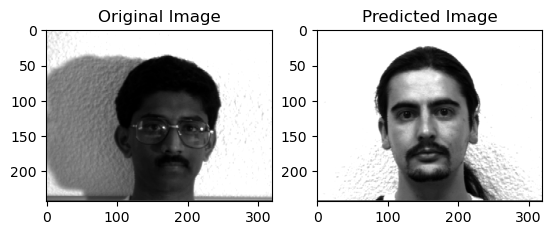

Incorrect


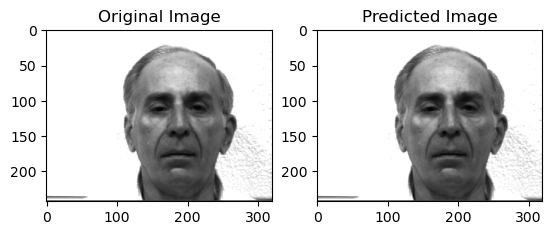

correct


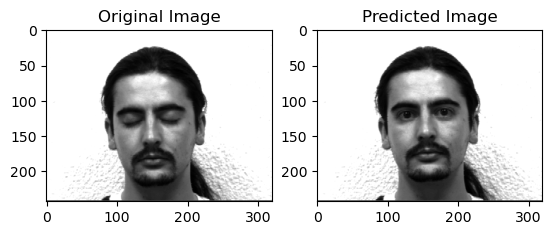

correct


0.8235294117647058

In [31]:
# Calculate PCA
sample_count, feature_count = X_train.shape
class_count = len(np.unique(y_train))
pca_eigenvalues, pca_eigenvectors, average_face = pca(X_train, (sample_count - class_count))

# Calculate LDA
component_count = 100
lda_eigenvalues, lda_eigenvectors = lda(np.dot(X_train - average_face, pca_eigenvectors), y_train, component_count)

# Calculate weight matrix
weight_matrix = np.dot(pca_eigenvectors, lda_eigenvectors)

# Project training data
projected_train_data = np.dot(X_train - average_face, weight_matrix)

# Compute accuracy
img_size = (height, width)
compute_accuracy(projected_train_data, X_test, y_test, y_train, weight_matrix, average_face, img_size, component_count)